<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1>Logistic Regression With Mini-Batch Gradient Descent </h1> 


<h2>Objective</h2>

<ul>
    <li>Represent your data as a Dataset object</li>
    <li>Create a Logistic Regression Model using PyTorch</li>
    <li>Set a Criterion to calculate Loss</li>
    <li>Create a Data Loader and set the Batch Size</li>
    <li>Create an Optimizer to update Model Parameters and set Learning Rate</li>
    <li>Train a Model</li>
</ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will learn how to train a PyTorch Logistic Regression model using Mini-Batch Gradient Descent.</p>

<ul>
    <li>Load Data</li>
    <li>Create the Model and Total Loss Function (Cost)</li>
    <li>Setting the Batch Size using a Data Loader</li>
    <li>Setting the Learning Rate</li>
    <li>Train the Model via Mini-Batch Gradient Descent</li>
    <li>Question</li>
</ul>
<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:


In [3]:
# Import the libraries we need for this lab

# Allows us to use arrays to manipulate and store data
import numpy as np
# Used to graph data and loss curves
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# PyTorch Library
import torch
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader
# PyTorch Neural Network
import torch.nn as nn

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch. 


In [4]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

Set the random seed:


In [5]:
# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(0)

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Load Data</h2>


The Dataset class represents a dataset. Your custom dataset should inherit Dataset which we imported above and override the following methods:

<p><code>__len__</code> so that len(dataset) returns the size of the dataset.</p>
<p><code>__getitem__</code> to support the indexing such that dataset[i] can be used to get ith sample</p>

Below we will create a sample dataset


In [6]:
# Create the custom Data class which inherits Dataset
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        # Create X values from -1 to 1 with step .1
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        # Create Y values all set to 0
        self.y = torch.zeros(self.x.shape[0], 1)
        # Set the X values above 0.2 to 1
        self.y[self.x[:, 0] > 0.2] = 1
        # Set the .len attribute because we need to override the __len__ method
        self.len = self.x.shape[0]
    
    # Getter that returns the data at the given index
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length of the dataset
    def __len__(self):
        return self.len

Make <code>Data</code> object


In [7]:
# Create Data object
data_set = Data()

We can see the X values of the dataset


In [8]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

We can see the Y values of the dataset which correspond to the class of the X value


In [9]:
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

We can get the length of the dataset


In [10]:
len(data_set)

20

We can get the label $y$ as well as the $x$ for the first sample 


In [11]:
x,y = data_set[0]
print("x = {},  y = {}".format(x,y))

x = tensor([-1.]),  y = tensor([0.])


We can get the label $y$ as well as the $x$ for the second sample:


In [12]:
x,y = data_set[1]
print("x = {},  y = {}".format(x,y))

x = tensor([-0.9000]),  y = tensor([0.])


 We can see we can separate the one-dimensional dataset into two classes:


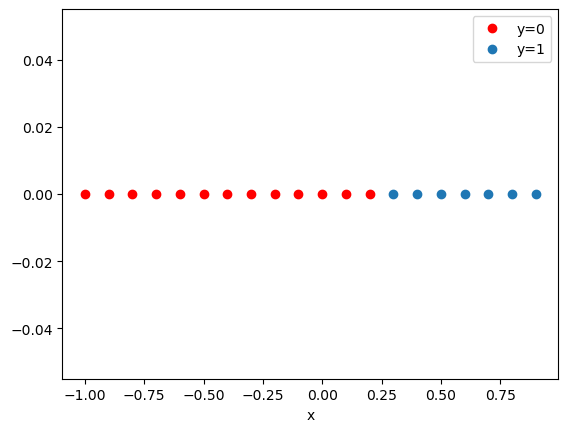

In [13]:
plt.plot(data_set.x[data_set.y==0], data_set.y[data_set.y==0], 'ro', label="y=0")
plt.plot(data_set.x[data_set.y==1], data_set.y[data_set.y==1]-1, 'o', label="y=1")
plt.xlabel('x')
plt.legend()          

<!--Empty Space for separating topics-->


<h2 id="Model_Cost">Create the Model and Total Loss Function (Cost)</h2>


For Logistic Regression typically we would not use PyTorch instead we would use Scikit-Learn as it is easier to use and set up. We are using PyTorch because it is good practice for deep learning. Scikit-Learn is typically used for Machine Learning while PyTorch is used for Deep Learning.


We will create a custom class that defines the architecture of Logistic Regression using PyTorch. Logistic Regression has a single layer where the input is the number of features an X value of the dataset has (dimension of X) and there is a single output. The output of the layer is put into a sigmoid function which is a function between 0 and 1. The larger the output of the layer the closer it is to 1 and the smaller the output is the closer it is to 0. The sigmoid function will allow us to turn this output into a classification problem. If the output value is closer to 1 it is one class if it is closer to 0 it is in another.


Sigmoid Function

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/labs/Module3/Logistic-curve.svg)


In [14]:
# Create logistic_regression class that inherits nn.Module which is the base class for all neural networks
class logistic_regression(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        # Single layer of Logistic Regression with number of inputs being n_inputs and there being 1 output 
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        # Using the input x value puts it through the single layer defined above then puts the output through the sigmoid function and returns the result
        yhat = torch.sigmoid(self.linear(x))
        return yhat

We can check the number of features an X value has, the size of the input, or the dimension of X


In [15]:
x,y = data_set[0]
len(x)

1

Create a logistic regression object or model, the input parameter is the number of dimensions.


In [16]:
# Create the logistic_regression result
model = logistic_regression(1)
model

logistic_regression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

We can make a prediction sigma $\sigma$ this uses the forward function defined above


In [17]:
x = torch.tensor([-1.0])
sigma = model.forward(x) # model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

We can also make a prediction using our data


In [18]:
x,y = data_set[2]

sigma = model(x)
sigma

tensor([0.6324], grad_fn=<SigmoidBackward0>)

Create a <code>plot_error_surfaces</code> object to visualize the data space and the learnable parameters space during training:

We can see on the Loss Surface graph, the loss value varying across w and b values with yellow being high loss and dark blue being low loss which is what we want

On the Loss Surface Contour graph we can see a top-down view of the Loss Surface graph


<Figure size 640x480 with 0 Axes>

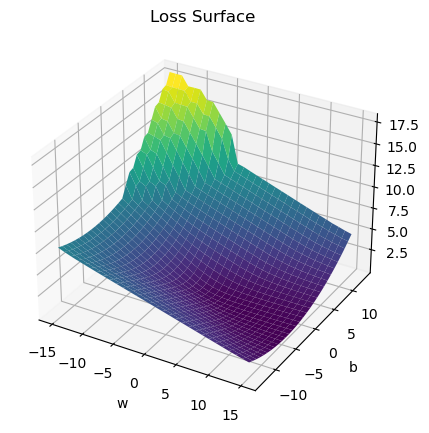

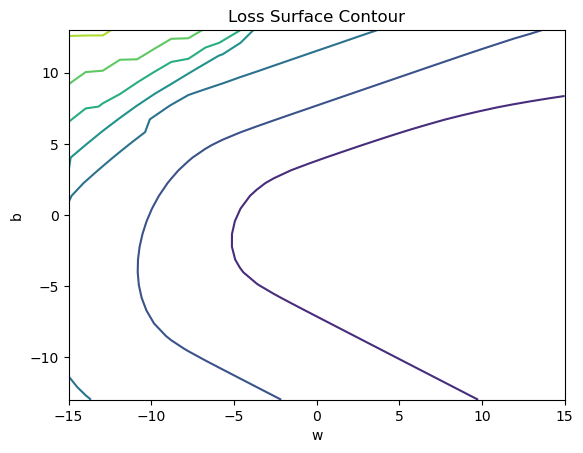

In [19]:
# Create the plot_error_surfaces object

# 15 is the range of w
# 13 is the range of b
# data_set[:][0] are all the X values
# data_set[:][1] are all the Y values

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1])

We define a criterion using Binary Cross Entropy Loss. This will measure the difference/loss between the prediction and actual value.


In [20]:
criterion = nn.BCELoss()

We have our samples:


In [21]:
x, y = data_set[0]
print("x = {},  y = {}".format(x,y))

x = tensor([-1.]),  y = tensor([0.])


We can make a prediction using the model:


In [22]:
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

We can calculate the loss 


In [23]:
loss = criterion(sigma, y)
loss

tensor(1.0016, grad_fn=<BinaryCrossEntropyBackward0>)

## Setting the Batch Size using a Data Loader


You have to use data loader in PyTorch that will output a  batch of data, the input is the <code>dataset</code> and  <code>batch_size</code>


In [24]:
batch_size=10

In [25]:
trainloader = DataLoader(dataset = data_set, batch_size = 10)

In [26]:
dataset_iter = iter(trainloader)

In [27]:
X,y=next(dataset_iter )

We can see here that 10 values the same as our batch size


In [ ]:
X

## Setting the Learning Rate


We can set the learning rate by setting it as a parameter in the optimizer along with the parameters of the logistic regression model we are training. The job of the optimizer, torch.optim.SGD, is to use the loss generated by the criterion to update the model parameters according to the learning rate. SGD stands for Stochastic Gradient Descent which typically means that the batch size is set to 1, but the data loader we set up above has turned this into Mini-Batch Gradient Descent.


In [30]:
learning_rate = 0.1

In [31]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

<!--Empty Space for separating topics-->


<h2 id="BGD">Train the Model via Mini-Batch Gradient Descent</h2>


We are going to train the model using various Batch Sizes and Learning Rates.


### Mini-Batch Gradient Descent


In this case, we will set the batch size of the data loader to 5 and the number of epochs to 250.


First, we must recreate the get_surface object again so that for each example we get a Loss Surface for that model only.


<Figure size 640x480 with 0 Axes>

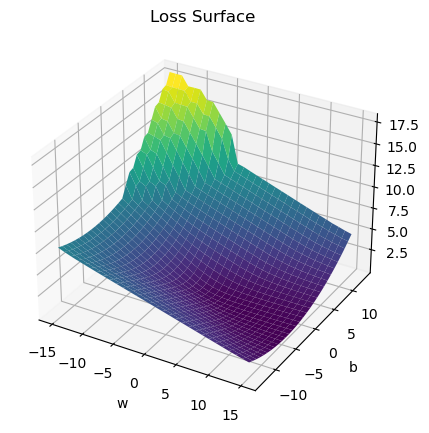

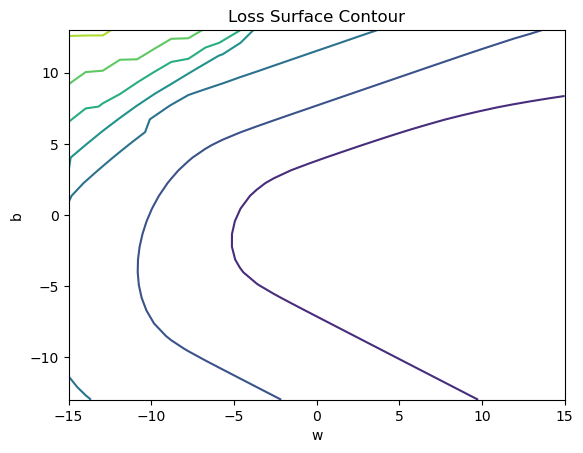

In [32]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

#### Train the Model


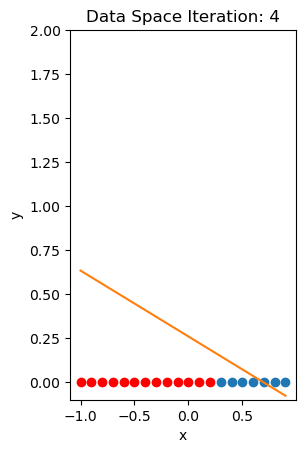

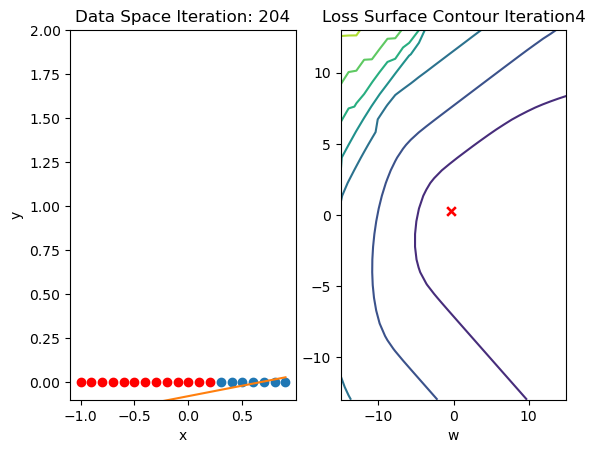

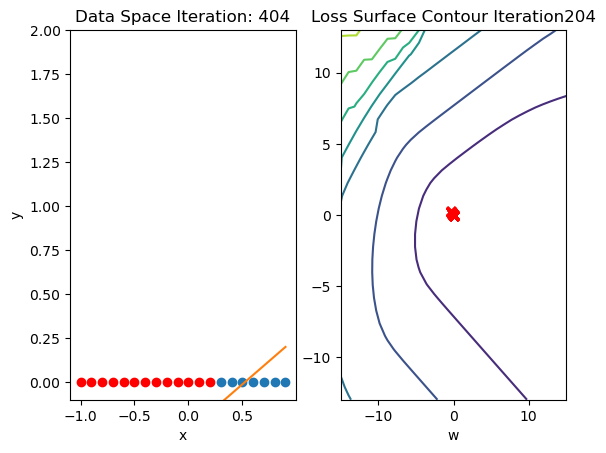

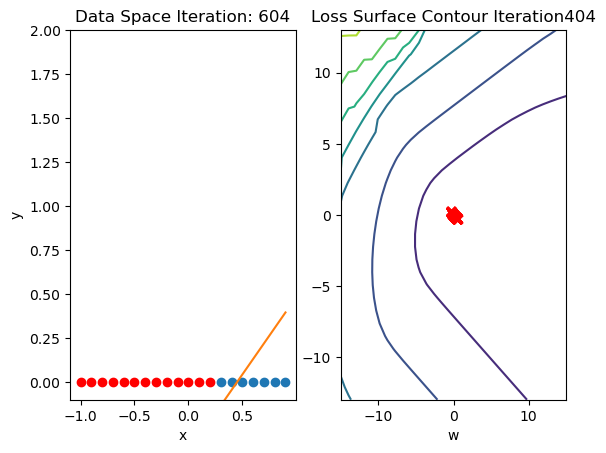

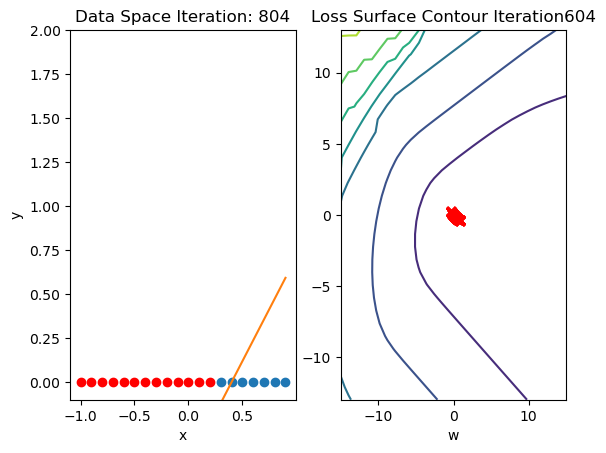

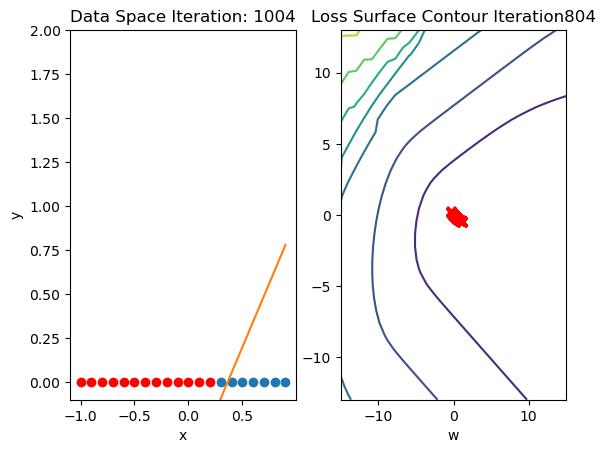

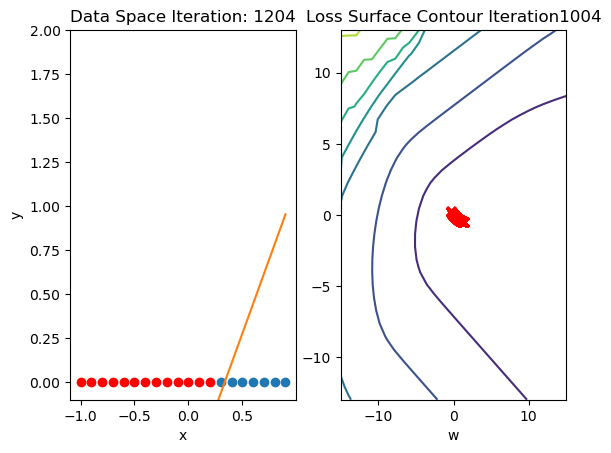

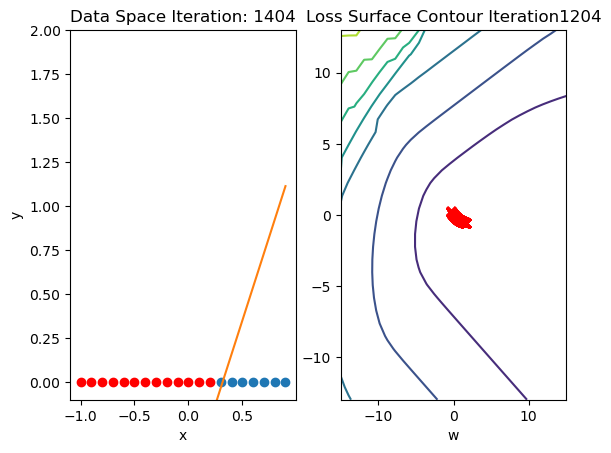

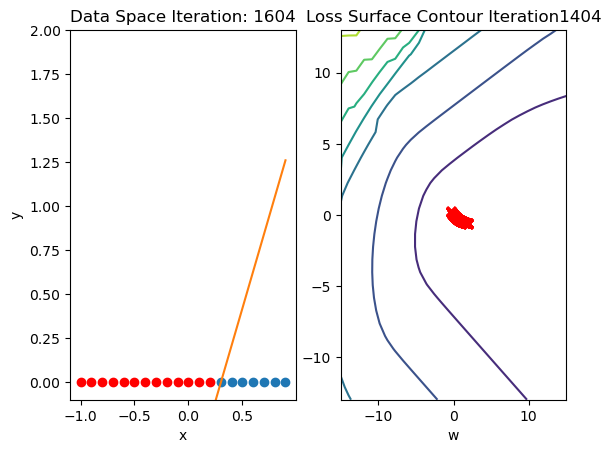

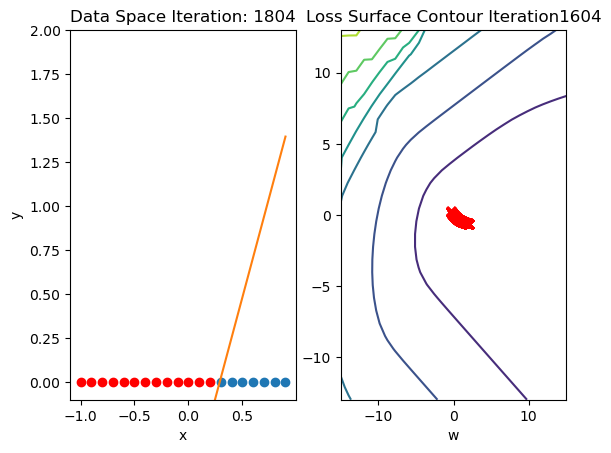

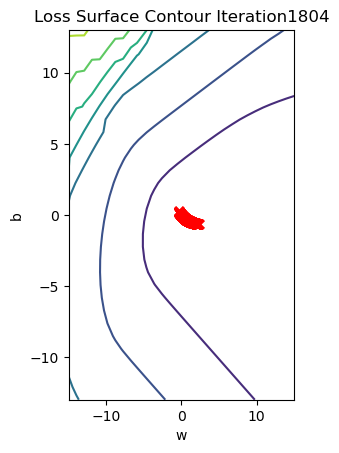

In [33]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 5
trainloader = DataLoader(dataset = data_set, batch_size = 5)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=500
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 50 == 0:
        get_surface.plot_ps()

We can see the final values of the weight and bias. This weight and bias correspond to the orange line in the Data Space graph and the final spot of the X in the Loss Surface Contour graph.


In [34]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.4503]) b =  tensor(-0.6884)


Now we can get the accuracy of the training data


In [35]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Finally, we plot the Cost vs Iteration graph, although it is erratic it is downward sloping.


Text(0, 0.5, 'Cost')

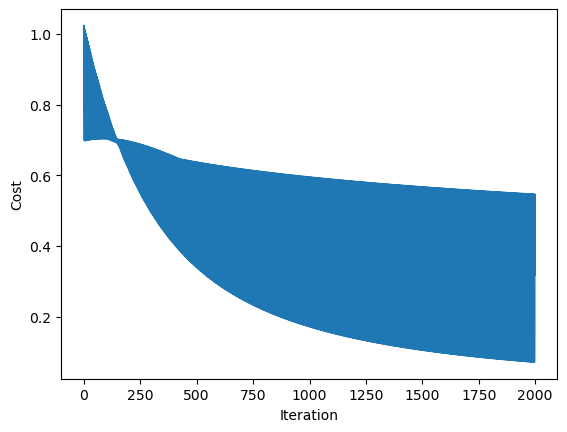

In [36]:
loss_values = [v.detach().numpy() for v in loss_values]
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")

### Stochastic Gradient Descent


In this case, we will set the batch size of the data loder to 1 so that the gradient descent will be performed for each example this is referred to as Stochastic Gradient Descent. The number of epochs is set to 100.

Notice that in this example the batch size is decreased from 5 to 1 so there would be more iterations. Due to this, we can reduce the number of iterations by decreasing the number of epochs. Due to the reduced batch size, we are optimizing more frequently so we don't need as many epochs.

First, we must recreate the `get_surface` object again so that for each example we get a Loss Surface for that model only.


In [ ]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

#### Train the Model


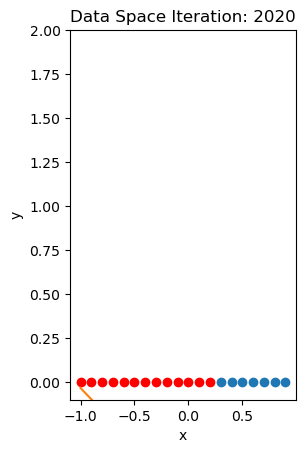

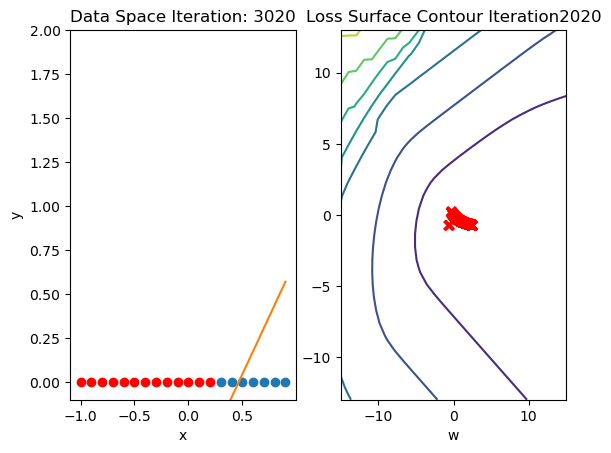

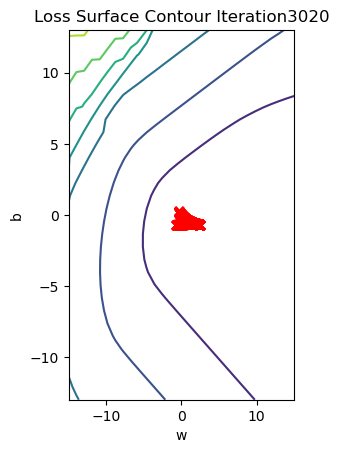

In [37]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 50 == 0:
        get_surface.plot_ps()

We can see the final values of the weight and bias. This weight and bias correspond to the orange line in the Data Space graph and the final spot of the X in the Loss Surface Contour graph.


In [38]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.3581]) b =  tensor(-0.6842)


Now we can get the accuracy of the training data


In [39]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Finally, we plot the Cost vs Iteration graph, although it is erratic it is downward sloping.


Text(0, 0.5, 'Cost')

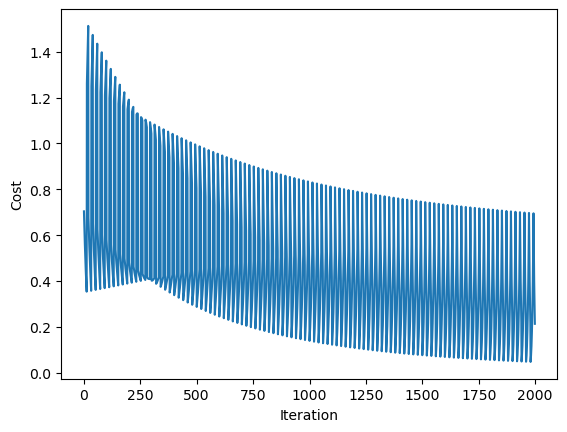

In [40]:
loss_values = [v.detach().numpy() for v in loss_values]
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")

### High Learning Rate


In this case, we will set the batch size of the data loder to 1 so that the gradient descent will be performed for each example this is referred to as Stochastic Gradient Descent. This time the learning rate will be set to .1 to represent a high learning rate and we will observe what will happen when we try to train.

First, we must recreate the `get_surface` object again so that for each example we get a Loss Surface for that model only.


<Figure size 640x480 with 0 Axes>

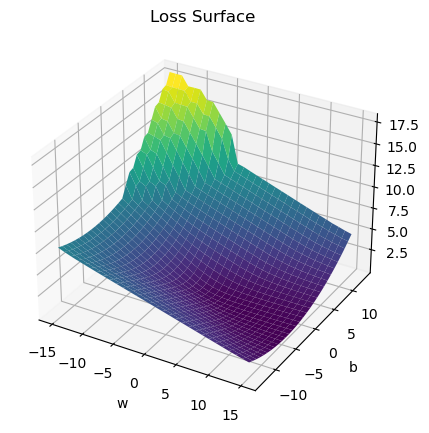

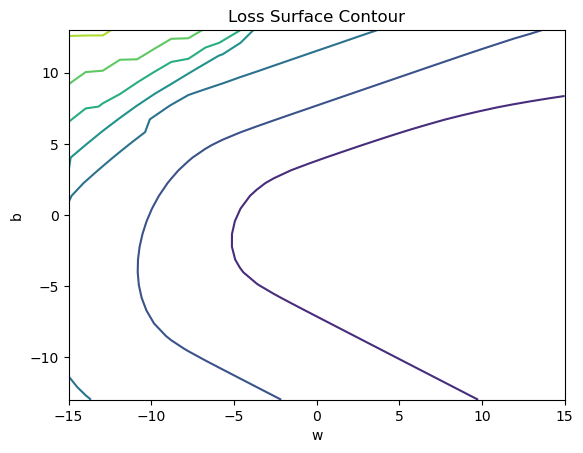

In [41]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

#### Train the Model


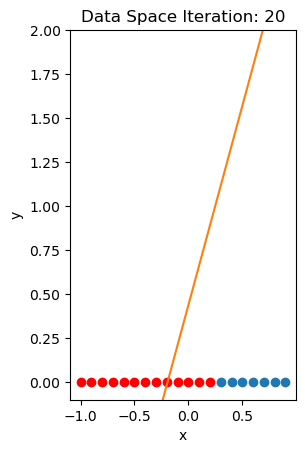

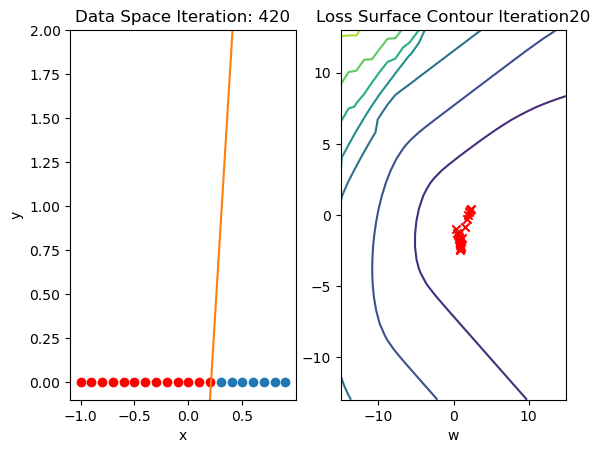

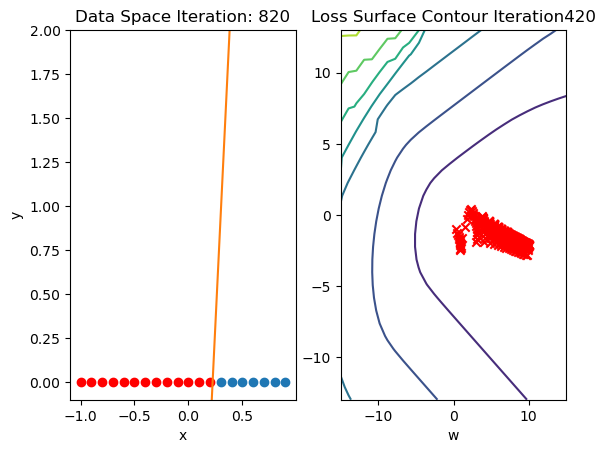

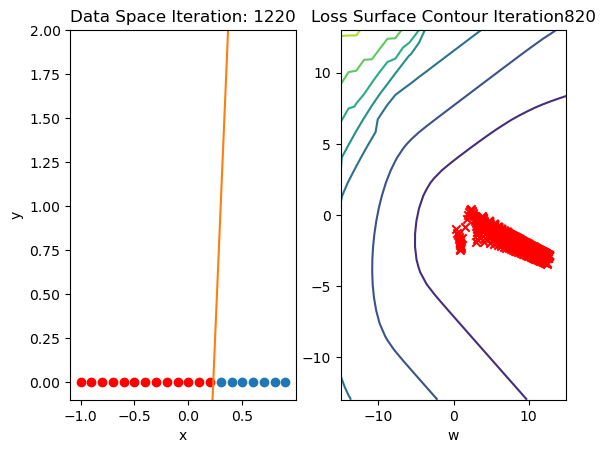

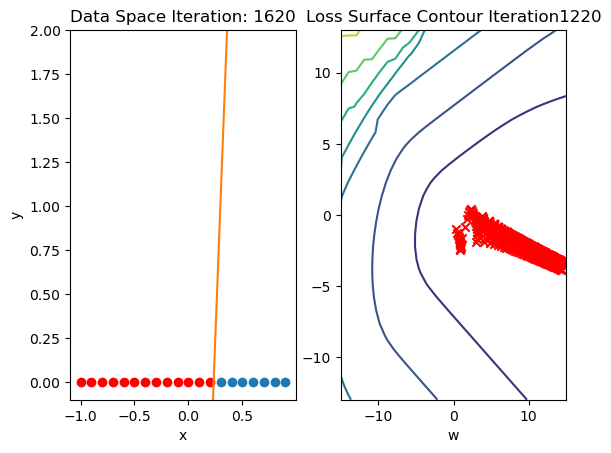

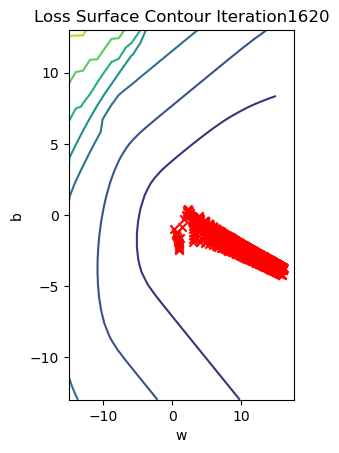

In [42]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion that will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

Notice in this example the due to the high learning rate the Loss Surface Contour graph has increased movement over the previous example and also moves in multiple directions due to the minimum being overshot.


We can see the final values of the weight and bias. This weight and bias correspond to the orange line in the Data Space graph and the final spot of the X in the Loss Surface Contour graph.


In [43]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([17.2987]) b =  tensor(-4.0843)


Now we can get the accuracy of the training data


In [44]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Finally, we plot the Cost vs Iteration graph, although it is erratic it is downward sloping.


Text(0, 0.5, 'Cost')

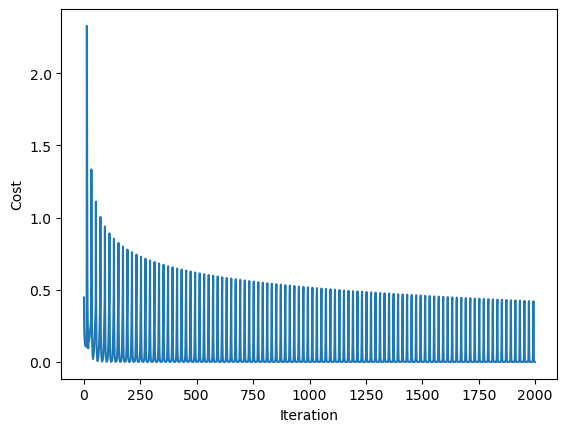

In [45]:
loss_values = [v.detach().numpy() for v in loss_values]
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## Question


Using the following code train the model using a `learning rate` of `.01`, `120 epochs`, and `batch_size` of `1`.


In [ ]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

#### Train the Model


In [ ]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs= 120
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss.detach().numpy())
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

<details><summary>Click here for the solution</summary>
<code>  
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs= 120
# This will store the loss over iterations so we can plot it at the end
loss_values = []
# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()
</code>
</details>


We can see the final values of the weight and bias. This weight and bias correspond to the orange line in the Data Space graph and the final spot of the X in the Loss Surface Contour graph.


In [ ]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

Now we can get the accuracy of the training data


In [ ]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Finally, we plot the Cost vs Iteration graph, although it is erratic it is downward sloping.


In [ ]:
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")

<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2022-01-01&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2022-01-01">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-23        | 2.0     | Shubham    | Migrated Lab to Markdown and added to course repo in GitLab |


<hr>


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
